Distribuição das classes no dataset original:
1    1499
0     301
2     197
3     152
Name: count, dtype: int64

Distribuição das classes após balanceamento:
0    1499
1    1499
2    1499
3    1499
Name: count, dtype: int64

Distribuição das classes no conjunto de treino:
1    1199
2    1199
3    1199
0    1199
Name: count, dtype: int64

Distribuição das classes no conjunto de teste:
2    300
1    300
3    300
0    300
Name: count, dtype: int64

Resultados da Validação Cruzada:

Accuracy:
Média (treino): 0.9995 ± 0.0003
Média (validação): 0.7846 ± 0.0141

Precision:
Média (treino): 0.9995 ± 0.0003
Média (validação): 0.7957 ± 0.0129

Recall:
Média (treino): 0.9995 ± 0.0003
Média (validação): 0.7846 ± 0.0141

F1:
Média (treino): 0.9995 ± 0.0003
Média (validação): 0.7863 ± 0.0134

Roc_auc:
Média (treino): 1.0000 ± 0.0000
Média (validação): 0.9282 ± 0.0067

Diferença entre treino e validação:
Accuracy: 0.2149
Precision: 0.2038
Recall: 0.2149
F1: 0.2133
Roc_auc: 0.0718

Métricas no Conjunto

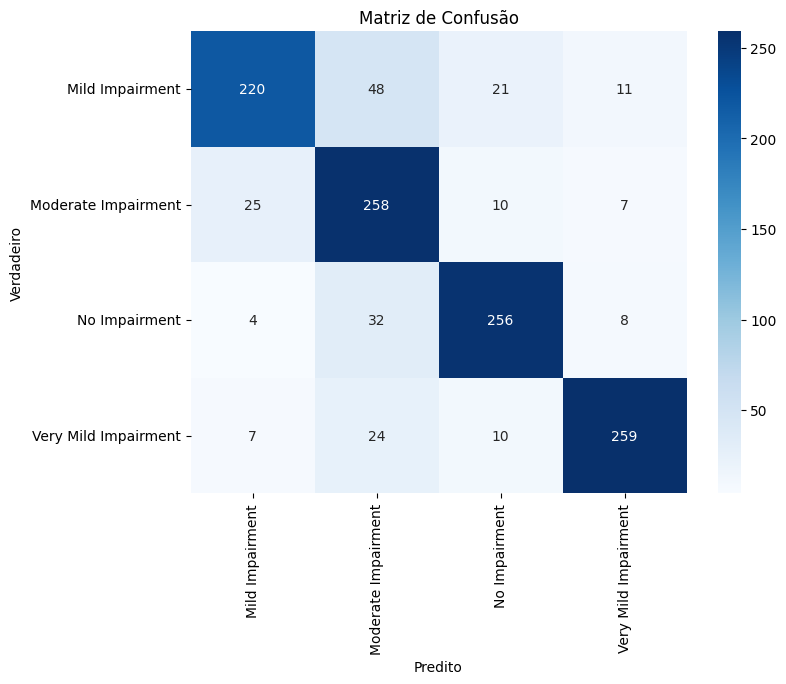

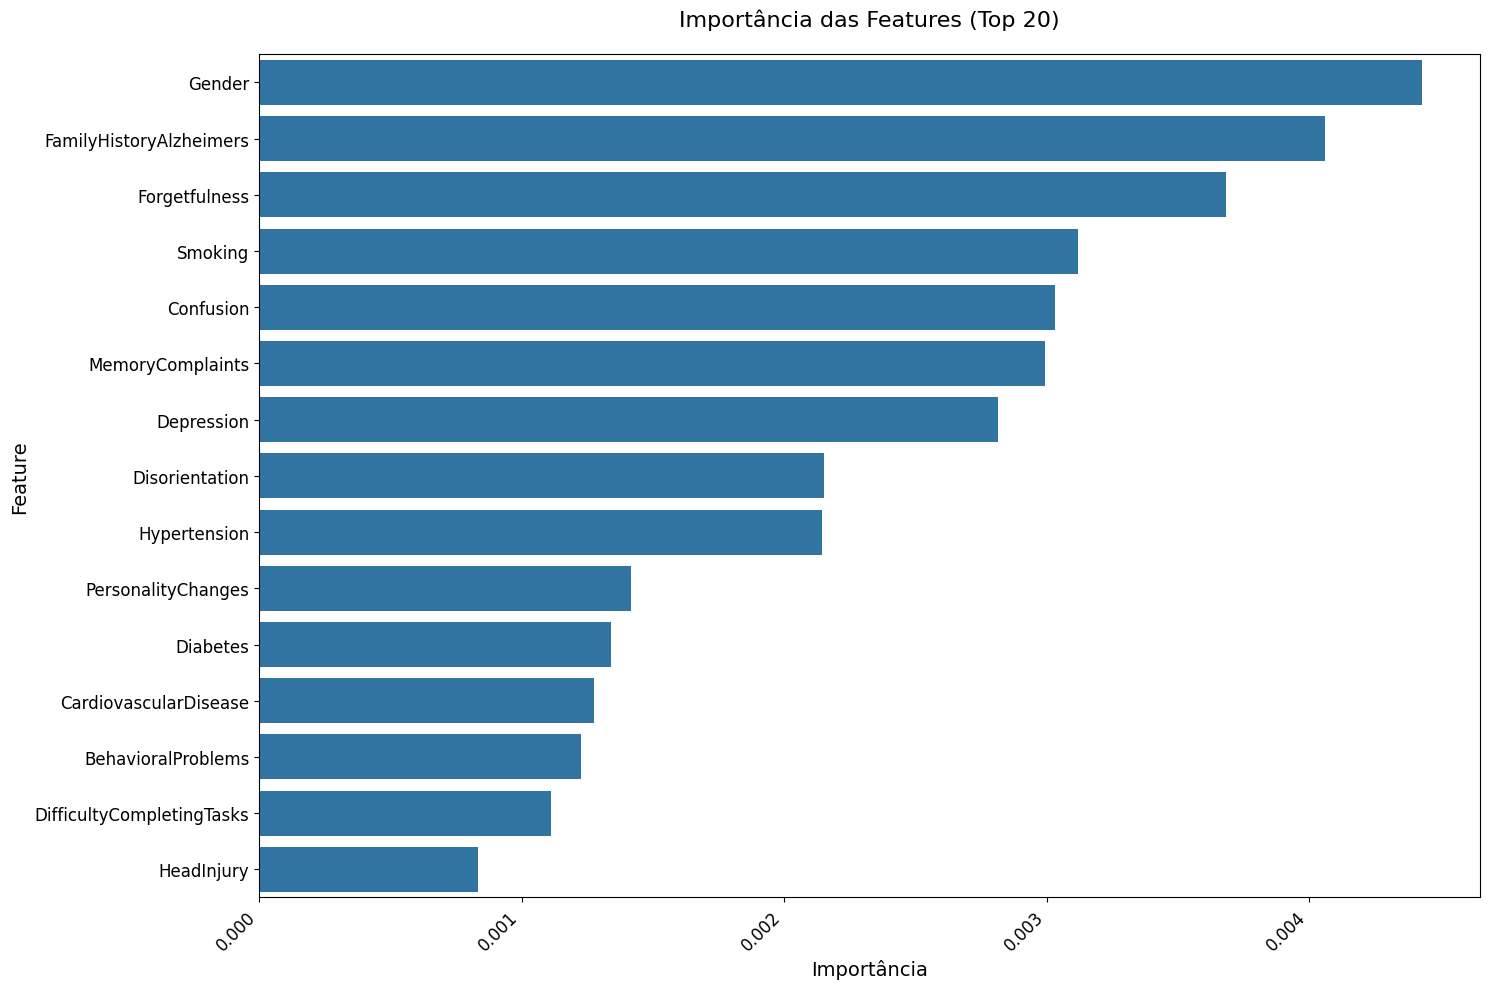

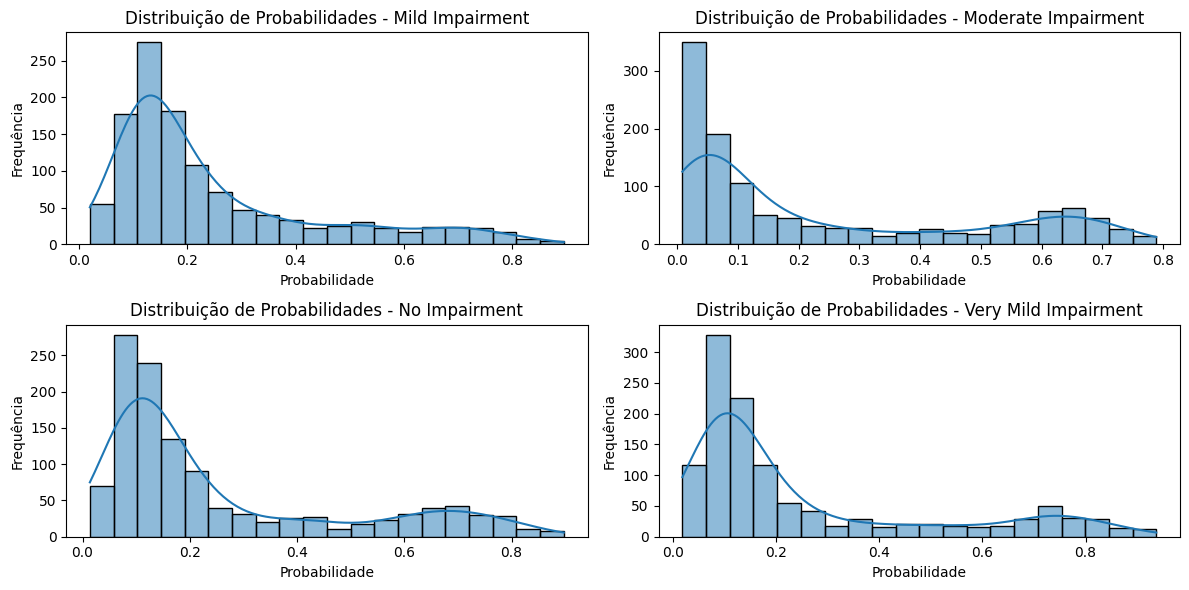

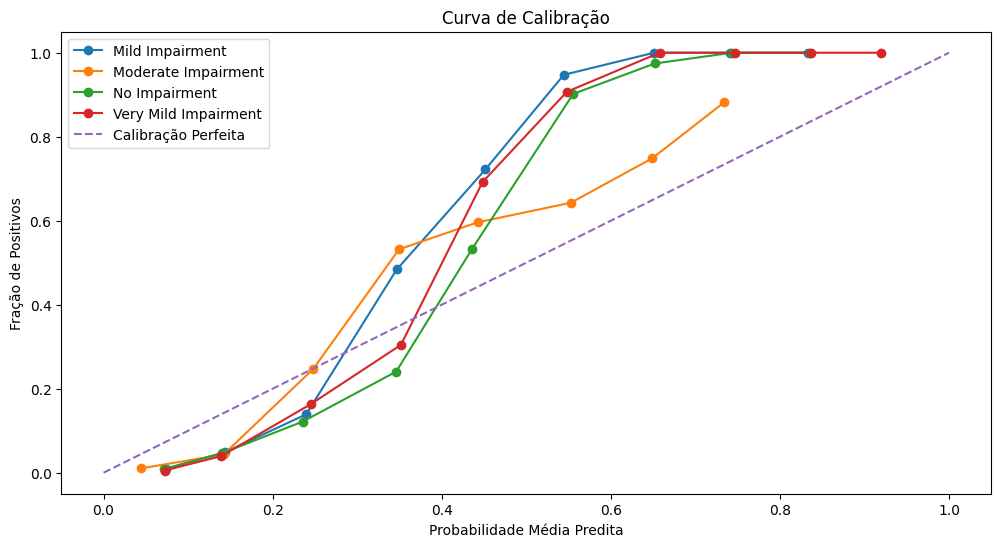


Modelo e objetos salvos com sucesso!


In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import joblib
import os

# Carregar o dataset
df = pd.read_csv('D:\\Projetos\\TrabalhoFinalDataScience\\AlzheimerEarlyDetection\\alzheimers_disease_data.csv')

# Criar a coluna target com base no MMSE
def classify_impairment(mmse):
    if mmse >= 27:
        return 'No Impairment'
    elif 24 <= mmse <= 26:
        return 'Very Mild Impairment'
    elif 19 <= mmse <= 23:
        return 'Mild Impairment'
    else:
        return 'Moderate Impairment'

df['Impairment'] = df['MMSE'].apply(classify_impairment)

# Remover colunas que não serão usadas
df = df.drop(['MMSE', 'Diagnosis', 'PatientID', 'DoctorInCharge'], axis=1)

# Separar features e target
X = df.drop('Impairment', axis=1)
y = df['Impairment']

# Codificar o target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Analisar a distribuição das classes
print("Distribuição das classes no dataset original:")
print(pd.Series(y).value_counts())

# Balancear o dataset antes da divisão treino/teste
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

print("\nDistribuição das classes após balanceamento:")
print(pd.Series(y_balanced).value_counts())

# Dividir em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, 
    y_balanced, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_balanced
)

print("\nDistribuição das classes no conjunto de treino:")
print(pd.Series(y_train).value_counts())

print("\nDistribuição das classes no conjunto de teste:")
print(pd.Series(y_test).value_counts())

# Escalonar as features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Seleção de features usando múltiplos métodos
selector1 = SelectKBest(score_func=f_classif, k=15)
selector2 = SelectKBest(score_func=mutual_info_classif, k=15)

X_train_f = selector1.fit_transform(X_train_scaled, y_train)
X_train_mi = selector2.fit_transform(X_train_scaled, y_train)

# PCA para redução de dimensionalidade
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)

# Combinar as features selecionadas
X_train_combined = np.hstack([X_train_f, X_train_mi, X_train_pca])

# Aplicar as mesmas transformações no conjunto de teste
X_test_f = selector1.transform(X_test_scaled)
X_test_mi = selector2.transform(X_test_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_test_combined = np.hstack([X_test_f, X_test_mi, X_test_pca])

# Criar modelos base
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)

gb = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    random_state=42
)

svm = SVC(
    C=10,
    kernel='rbf',
    gamma='scale',
    class_weight='balanced',
    probability=True,
    random_state=42
)

# Criar o ensemble
ensemble = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('gb', gb),
        ('svm', svm)
    ],
    voting='soft',
    weights=[2, 1, 1]
)

# Validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Métricas para validação cruzada
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro',
    'f1': 'f1_macro',
    'roc_auc': 'roc_auc_ovo'
}

# Realizar validação cruzada
cv_results = cross_validate(
    ensemble,
    X_train_combined,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True
)

# Imprimir resultados da validação cruzada
print("\nResultados da Validação Cruzada:")
for metric in scoring.keys():
    print(f"\n{metric.capitalize()}:")
    print(f"Média (treino): {cv_results[f'train_{metric}'].mean():.4f} ± {cv_results[f'train_{metric}'].std():.4f}")
    print(f"Média (validação): {cv_results[f'test_{metric}'].mean():.4f} ± {cv_results[f'test_{metric}'].std():.4f}")

# Verificar overfitting
print("\nDiferença entre treino e validação:")
for metric in scoring.keys():
    diff = cv_results[f'train_{metric}'].mean() - cv_results[f'test_{metric}'].mean()
    print(f"{metric.capitalize()}: {diff:.4f}")

# Treinar o modelo final
ensemble.fit(X_train_combined, y_train)

# Avaliar no conjunto de teste
y_pred = ensemble.predict(X_test_combined)
y_proba = ensemble.predict_proba(X_test_combined)

# Métricas de avaliação
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='macro')
test_recall = recall_score(y_test, y_pred, average='macro')
test_f1 = f1_score(y_test, y_pred, average='macro')
test_roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovo')

print("\nMétricas no Conjunto de Teste:")
print(f"Acurácia: {test_accuracy:.4f}")
print(f"Precisão: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_f1:.4f}")
print(f"ROC AUC: {test_roc_auc:.4f}")

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Importância das features (apenas para o Random Forest)
importances = ensemble.named_estimators_['rf'].feature_importances_

# Obter os nomes das features selecionadas
selected_features = X.columns[selector1.get_support()].tolist()

# Criar DataFrame com os nomes das features
feature_imp = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances[:len(selected_features)]
})
feature_imp = feature_imp.sort_values('Importance', ascending=False)

# Criar o gráfico
plt.figure(figsize=(15, 10))
ax = sns.barplot(x='Importance', y='Feature', data=feature_imp)

# Ajustar os labels
plt.title('Importância das Features (Top 20)', fontsize=16, pad=20)
plt.xlabel('Importância', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Ajustar os ticks
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Ajustar o layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()

# Verificar distribuição das probabilidades
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.histplot(y_proba[:, i], bins=20, kde=True)
    plt.title(f'Distribuição de Probabilidades - {le.classes_[i]}')
    plt.xlabel('Probabilidade')
    plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

# Verificar calibração do modelo
from sklearn.calibration import calibration_curve
plt.figure(figsize=(12, 6))
for i in range(4):
    prob_true, prob_pred = calibration_curve(y_test == i, y_proba[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=le.classes_[i])
plt.plot([0, 1], [0, 1], linestyle='--', label='Calibração Perfeita')
plt.xlabel('Probabilidade Média Predita')
plt.ylabel('Fração de Positivos')
plt.title('Curva de Calibração')
plt.legend()
plt.show()

# Salvar o modelo e o scaler
# Criar diretório se não existir
os.makedirs('models', exist_ok=True)

# Salvar o modelo
joblib.dump(ensemble, 'models/alzheimer_csv_model.pkl')

# Salvar o scaler
joblib.dump(scaler, 'models/scaler.pkl')

# Salvar o label encoder
joblib.dump(le, 'models/label_encoder.pkl')

# Salvar os seletores de features
joblib.dump(selector1, 'models/feature_selector1.pkl')
joblib.dump(selector2, 'models/feature_selector2.pkl')

# Salvar o PCA
joblib.dump(pca, 'models/pca.pkl')

print("\nModelo e objetos salvos com sucesso!")